# Run the soap search

In [17]:
import matplotlib.pyplot as plt
import soapcw
import numpy as np

### Search for a sinusoid in random noise

Initially we can generate some random gaussian noise, then add a signal which drifts in frequency.
</br>
The signal is added by arbritrarily adding 2 to the result in each bin.

In [18]:
simp_nsft = 100
simp_freqrange = 70
spect = np.random.normal(size = (simp_nsft,simp_freqrange))
signal_track = np.linspace(20,50,simp_nsft).astype(np.int)
for t,f in enumerate(signal_track):
    spect[t,f] += 2

We can generate the transition probability, here this is the probability of the track jumping up center or down a frequency bin. 
</br>
The input to this takes on argument as it is set up to be symmetric, i.e. the probability of jumping up or down a frequency bin is the same.
and in this case all jumps are equally probable.

In [19]:
simp_tr = soapcw.tools.transition_matrix(1)

In [20]:
simp_track = soapcw.single_detector(simp_tr,spect)

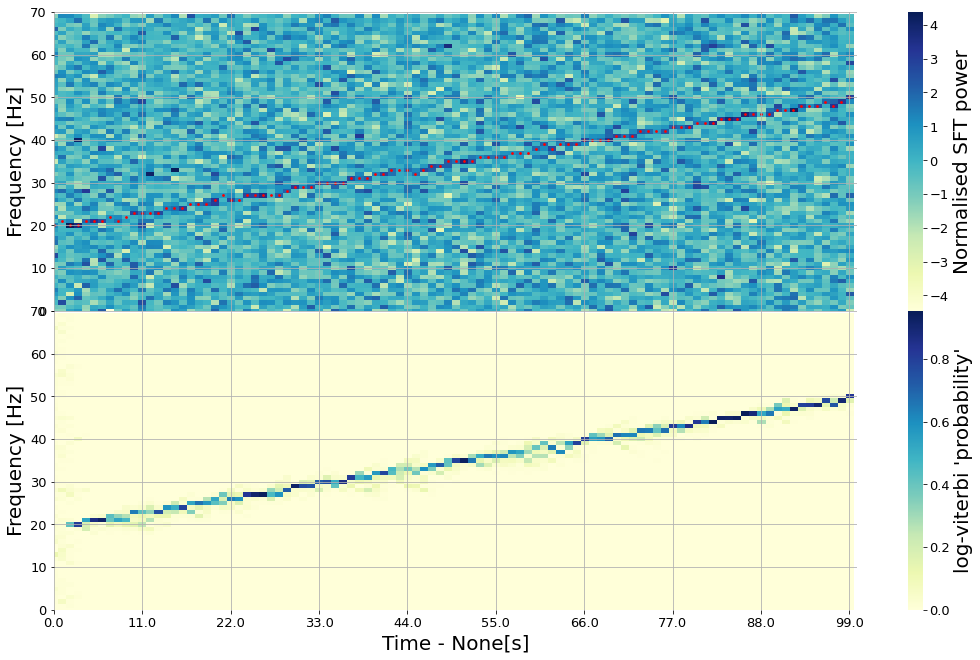

In [21]:
fg = soapcw.plots.plot_single(spect,soapout = simp_track)

## Run the search on a continuous gravitational wave signal

Set up the signal to have the parameters below, the number of sfts, start time and noise floors (Snh,Snl) are based on the S6 dataset.

In [23]:
sig = soapcw.cw.GenerateSignal()
# define signal parameters
sig.alpha = 3.310726752188296
sig.delta = -0.8824241920781501
sig.cosi = -0.63086
sig.phi0 = 4.007
sig.psi = 0.52563
sig.f = [100.05,-1e-17,0]
sig.tref = 946339148.816094

In [24]:
# set the spectrogram parameters
nsft, tstart, tsft, flow, fhigh = 22538, 931042949, 1800., 100.0,100.1

Here we can define the noise floor for two detectors H1 and L1. 

In [25]:
med_Snh = 1.3628690586455306e-45
med_Snl = 1.71197844026147e-45

#### One detector example

We can generate a signal with the parameters defined above, here we set the SNR of the signal to 80 and the value of h0 is adjusted to give this 'recovered' SNR.

In [26]:
# generate one detector spectrogram
one_spect_ng = sig.get_spectrogram(tstart = tstart, nsft=nsft,tsft=tsft,fmin=flow,fmax=fhigh,Sn={"H1":med_Snh},snr=80)

We can then sum the SFTs over one day to increase the SNR in any given bin

In [27]:
# can sum the sfts over one day if necessary
one_spect_ng.sum_sfts()

In [28]:
tr_1 = soapcw.tools.transition_matrix(1.0)

In [29]:
one_tracks_ng = soapcw.single_detector(tr_1,one_spect_ng.H1.summed_norm_sft_power)

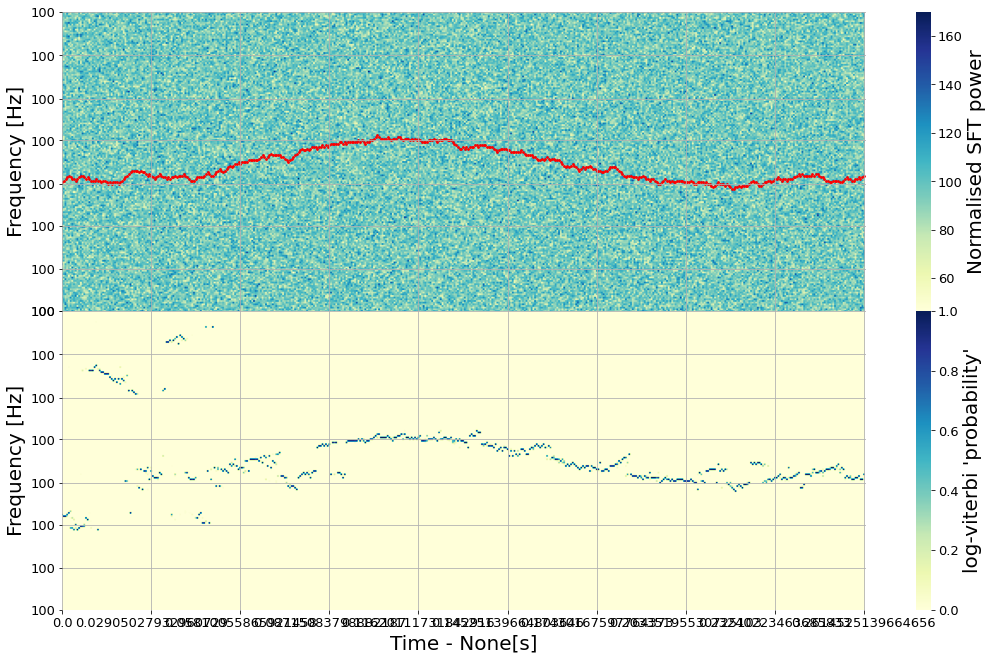

In [30]:
one_fg = soapcw.plots.plot_single(one_spect_ng.H1.summed_norm_sft_power, soapout=one_tracks_ng, fmin=flow,fmax=fhigh)

### Two detector example

In [31]:
tr_2 = soapcw.tools.transition_matrix_2d(1.1,1e400,1e400)

#### Data with no gaps

In [32]:
#generate the spectrogram with above parameters
spect_ng = sig.get_spectrogram(tstart = tstart, nsft=nsft,tsft=tsft,fmin=flow,fmax=fhigh,Sn={"H1":med_Snh,"L1":med_Snl},snr=130)

In [33]:
spect_ng.sum_sfts()

In [34]:
tracks_ng = soapcw.two_detector(tr_2,spect_ng.H1.summed_norm_sft_power,spect_ng.L1.summed_norm_sft_power)

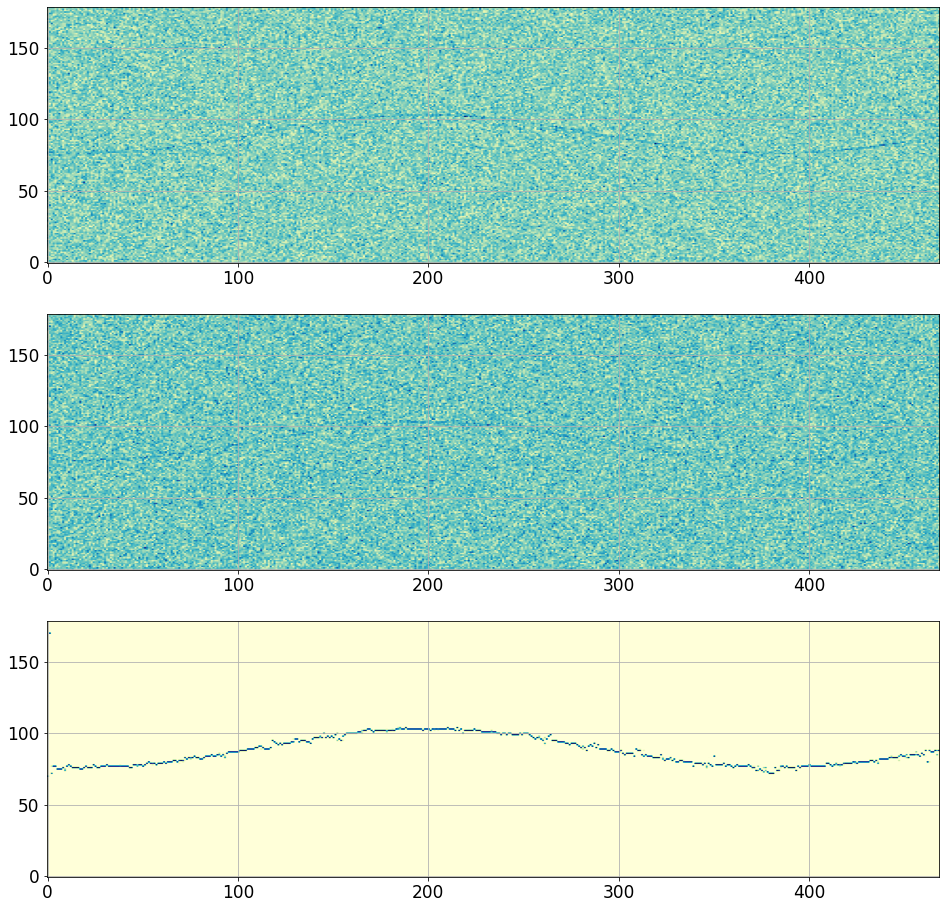

In [35]:
fig_ng, ax_ng = plt.subplots(figsize=(16,16),nrows=3)
ax_ng[0].imshow(spect_ng.H1.summed_norm_sft_power.T,aspect="auto",origin="lower",cmap="YlGnBu")
ax_ng[1].imshow(spect_ng.L1.summed_norm_sft_power.T,aspect="auto",origin="lower",cmap="YlGnBu")
ax_ng[2].imshow(tracks_ng.vitmap.T,aspect="auto",origin="lower",cmap="YlGnBu")

#### data with gaps

initially define the moving noise floor with same length as data and introduce gaps in the data

In [36]:
# moving noise floors (getting less sensitive in H1)
Snh = np.linspace(0.8,1.1,nsft)*med_Snh
Snl = np.linspace(1.0,1.0,nsft)*med_Snl
# random gaps
size = 1000 # size of gap
# set noise floor to nan where there are gaps
h_gaps = np.array(np.random.rand(3)*(nsft-size)).astype(int)
for gap in h_gaps:
    Snh[gap-size:gap+size] = np.nan
l_gaps = np.array(np.random.rand(3)*(nsft-size)).astype(int)
for gap in l_gaps:
    Snl[gap-size:gap+size] = np.nan

In [37]:
#generate the spectrogram with above parameters
spect_g = sig.get_spectrogram(tstart = tstart, nsft=nsft,tsft=tsft,fmin=flow,fmax=fhigh,Sn={"H1":Snh,"L1":Snl},snr=100)

In [38]:
spect_g.sum_sfts()

In [39]:
tracks_g = soapcw.two_detector(tr_2,spect_g.H1.summed_norm_sft_power,spect_g.L1.summed_norm_sft_power)

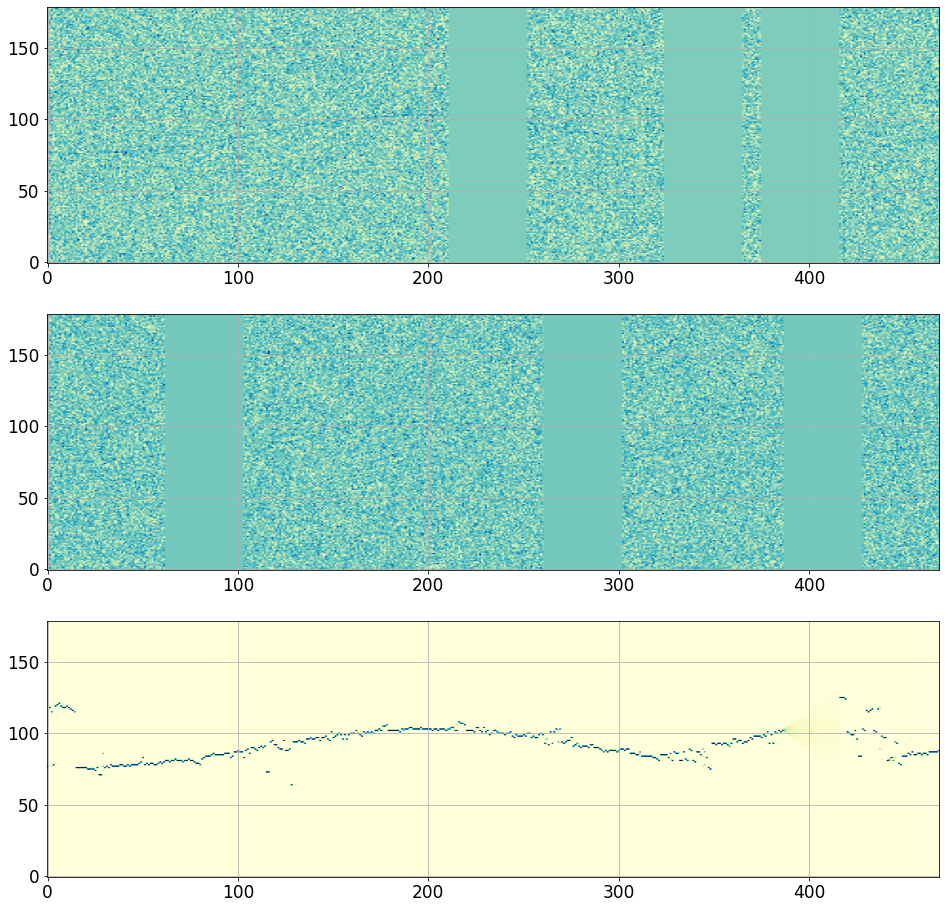

In [40]:
fig_g, ax_g = plt.subplots(figsize=(16,16),nrows=3)
ax_g[0].imshow(spect_g.H1.summed_norm_sft_power.T,aspect="auto",origin="lower",cmap="YlGnBu")
ax_g[1].imshow(spect_g.L1.summed_norm_sft_power.T,aspect="auto",origin="lower",cmap="YlGnBu")
ax_g[2].imshow(tracks_g.vitmap.T,aspect="auto",origin="lower",cmap="YlGnBu")

## Searches using the line aware statistic

Here we use the line aware statistic which takes as input the lookup table file generated with scripts described in "generate_lookup_table".

### one detector

In [41]:
# change the number of elements to reduce generation time (500 -> 100)
powers = np.linspace(1,200,500)
v1d = soapcw.line_aware_stat.gen_lookup_python.LineAwareStatistic(
    powers,
    ndet=1,
    signal_prior_width=2.0,
    line_prior_width=9.0,
    noise_line_model_ratio=0.0)
v1d.save_lookup("./")

In [42]:
tr_1_line = soapcw.tools.transition_matrix(1.0)

In [43]:
one_det_line_aware = soapcw.single_detector(tr_1_line,one_spect_ng.H1.summed_norm_sft_power,lookup_table="./signoiseline_1det_2.0_9.0_0.0.txt")

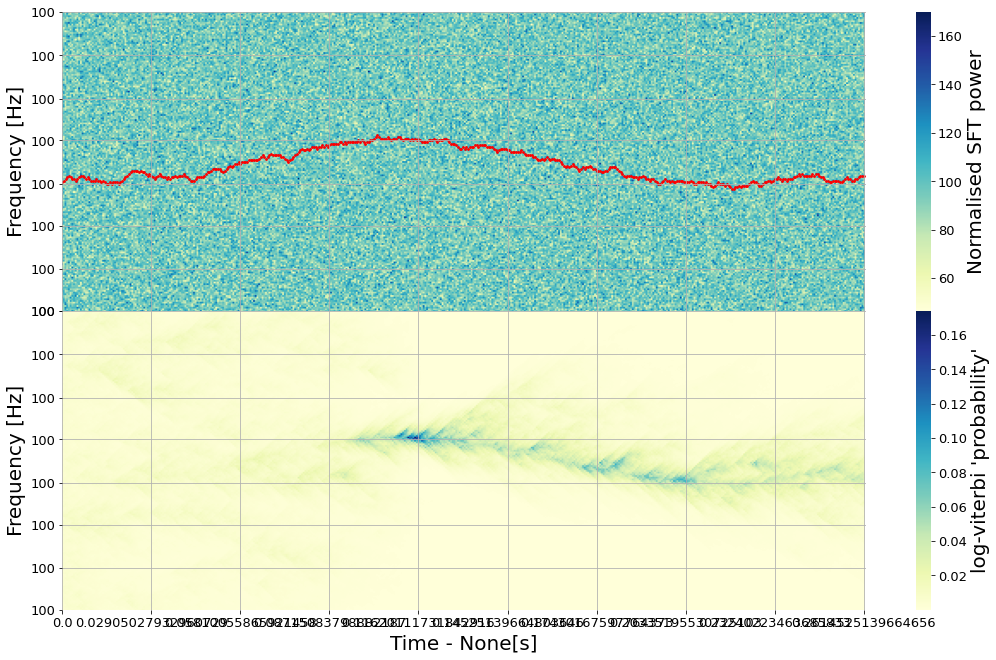

In [44]:
one_fg = soapcw.plots.plot_single(one_spect_ng.H1.summed_norm_sft_power, soapout=one_det_line_aware, fmin=flow,fmax=fhigh)

### two detector

Here we can generate a lookup table for two detector

In [45]:
v2d = soapcw.line_aware_stat.gen_lookup_python.LineAwareStatistic(
    powers,
    ndet=2,
    signal_prior_width=4.0,
    line_prior_width=5.0,
    noise_line_model_ratio=0.038)

In [46]:
tr_2_line = soapcw.tools.transition_matrix_2d(1.0,1e300,1e300)

In [47]:
tracks_ng_line = soapcw.two_detector(tr_2_line,spect_ng.H1.summed_norm_sft_power,spect_ng.L1.summed_norm_sft_power,lookup_table_2det=v2d)

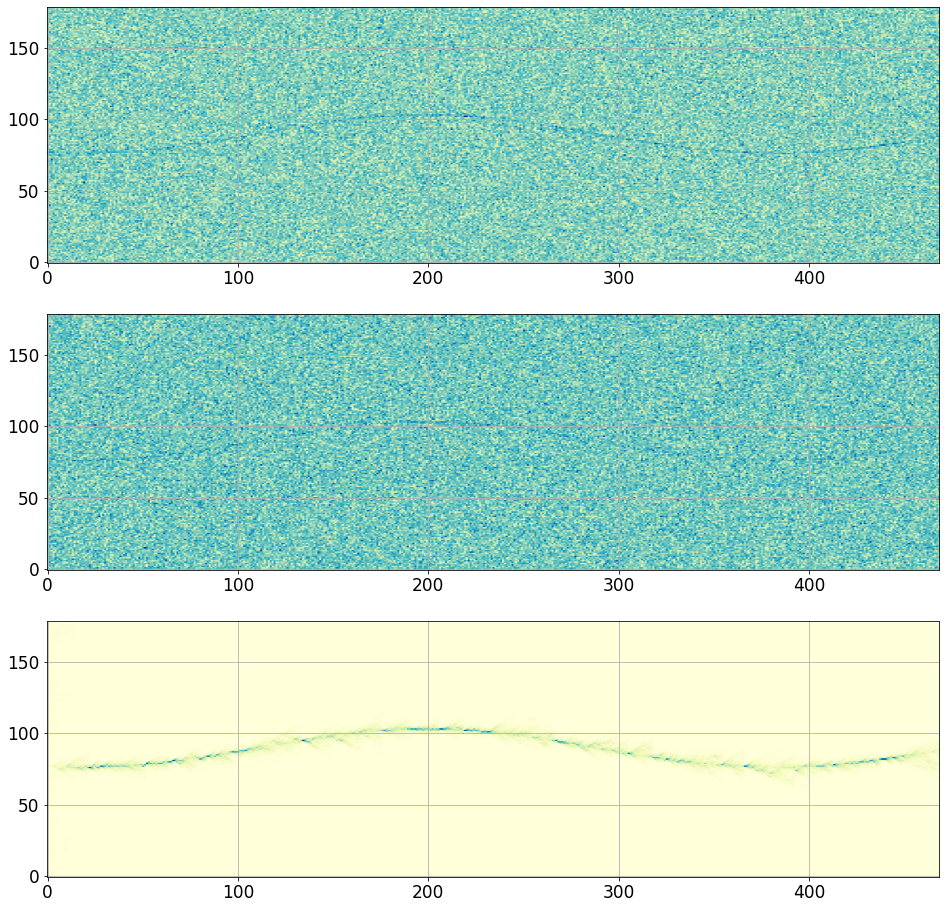

In [48]:
fig_g, ax_g = plt.subplots(figsize=(16,16),nrows=3)
ax_g[0].imshow(spect_ng.H1.summed_norm_sft_power.T,aspect="auto",origin="lower",cmap="YlGnBu")
ax_g[1].imshow(spect_ng.L1.summed_norm_sft_power.T,aspect="auto",origin="lower",cmap="YlGnBu")
ax_g[2].imshow(tracks_ng_line.vitmap.T,aspect="auto",origin="lower",cmap="YlGnBu")

Here we generate a lookup table for the single and multiple detector statitstic as the data has gaps, in the gap we want to only use data from a single detector

In [50]:
v2d = soapcw.line_aware_stat.gen_lookup_python.LineAwareStatistic(
    powers,
    ndet=2,
    signal_prior_width=4.0,
    line_prior_width=5.0,
    noise_line_model_ratio=0.038)
v2d.save_lookup("./")

In [51]:
v21d = soapcw.line_aware_stat.gen_lookup_python.LineAwareStatistic(
    powers,
    ndet=1,
    signal_prior_width=4.0,
    line_prior_width=5.0,
    noise_line_model_ratio=0.038)
v21d.save_lookup("./")

In [52]:
tracks_g_line = soapcw.two_detector(tr_2_line,spect_g.H1.summed_norm_sft_power,spect_g.L1.summed_norm_sft_power,lookup_table_2det="./signoiseline_2det_4.0_5.0_0.038.txt",lookup_file_1det="./signoiseline_1det_4.0_5.0_0.038.txt")

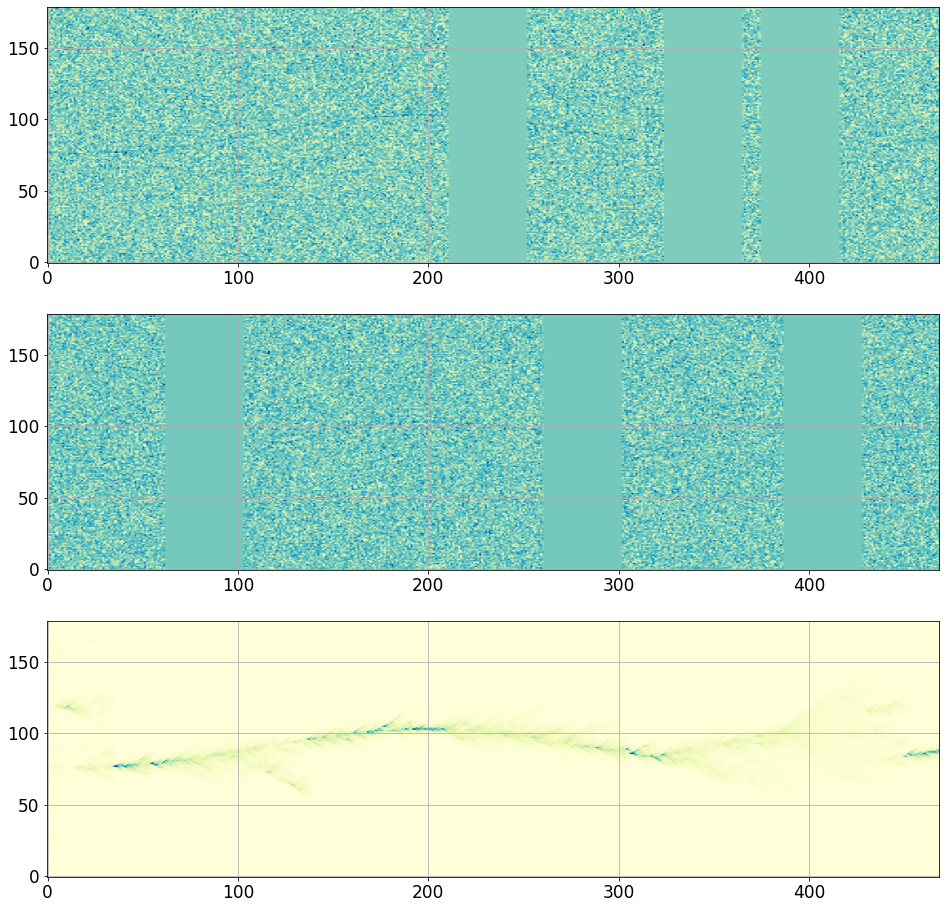

In [53]:
fig_g, ax_g = plt.subplots(figsize=(16,16),nrows=3)
ax_g[0].imshow(spect_g.H1.summed_norm_sft_power.T,aspect="auto",origin="lower",cmap="YlGnBu")
ax_g[1].imshow(spect_g.L1.summed_norm_sft_power.T,aspect="auto",origin="lower",cmap="YlGnBu")
ax_g[2].imshow(tracks_g_line.vitmap.T,aspect="auto",origin="lower",cmap="YlGnBu")